In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from pathlib import Path


def frame_counts(csv_file, frames):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    if not isinstance(frames, list):
        frames = [frames]
    counts = []
    for f in frames:
        counts.append(len(spots[spots["FRAME"] == f]))
    return counts

def frame_clusters_with_dbscan(csv_file, frame, db_eps, db_min_sample):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    spots_frame = spots[spots["FRAME"] == frame]
    pos_x = spots_frame["POSITION_X"].values
    pos_y = spots_frame["POSITION_Y"].values
    pos = np.vstack((pos_x, pos_y)).T
    if len(pos) == 0:
        return 0, pos, []
    clustering = DBSCAN(eps=DB_EPS, min_samples=DB_MIN_SAMPLES).fit(pos)
    num_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    return num_clusters, pos, clustering.labels_

def plot_clusters(ax, img, frame, pos, labels):
    with tifffile.TiffFile(img) as tif:
        frame_img = tif.pages[frame*2].asarray()
    ax.imshow(frame_img, cmap="gray")
    for label in set(labels):
        if label == -1:
            continue
        cluster_pos = pos[labels == label]
        if len(cluster_pos) < 3:
            print("Skipping cluster with less than 3 points: ", img)
            continue
        hull = ConvexHull(cluster_pos)
        ax.plot(cluster_pos[hull.vertices, 0], cluster_pos[hull.vertices, 1], "r-")

def get_files_list(root):
    root = Path(root)
    return [root/f for f in os.listdir(root) if not f.startswith('.')]

# All together

In [5]:
def plot_group_statistics_all_together(csv_files, db_eps, db_min_sample, frame_to_normalize_by_plaques, names, title, savepath=None):

    timepoints = np.arange(0, 46)

    linestyles = ['-', '--', '*', '-*']
    colors = ['blue', 'orange', 'green', 'black']

    # compute inf counts for all frames
    normalized_counts = []
    all_counts = []
    for csv_group in csv_files:
        normalized_counts_group = []
        couts_group = []
        for csv_file in csv_group:
            # num_cluster, _, _ = frame_clusters_with_dbscan(csv_file, frame_to_normalize_by_plaques, db_eps, db_min_sample)
            
            # Just add this line because for non-syncytia files, you manually cropped single plaques
            num_cluster = 1

            # Compute normalized counts for each frame
            counts = frame_counts(csv_file, list(timepoints))
            normalized_counts_group.append([c / num_cluster for c in counts])
            couts_group.append(counts)
        normalized_counts.append(normalized_counts_group)
        all_counts.append(couts_group)

    # Plot all data frame by frame for sanity check
    cm = plt.get_cmap('gist_rainbow')
    plt.figure(figsize=(15, 15))
    for i, group_counts in enumerate(all_counts):
        linestyle = linestyles[i]
        for j in range(len(group_counts)):
            plt.plot(group_counts[j], label=names[i] + '/' + csv_files[i][j].name.split('-')[0], linestyle=linestyle, color=cm(1.0 * j / len(group_counts)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Inf Counts for every frame, every sample")
    
    # Calculate mean and standard deviation for each group
    means = [np.mean(group_counts, axis=0) for group_counts in normalized_counts]
    stds = [np.std(group_counts, axis=0) for group_counts in normalized_counts]

    # Plot group statistics
    plt.figure(figsize=(15, 15))
    for g in range(len(means)):
        plt.plot(timepoints, means[g], label=names[g], linestyle=linestyles[g], color=colors[g], linewidth=3)
        plt.fill_between(timepoints, means[g] - stds[g], means[g] + stds[g], alpha=0.3, color=colors[g])
    
    # Add legend
    plt.xlabel('Frames')
    plt.ylabel(f'Number of infected cells, normalized by number of Plaques at frame {frame_to_normalize_by_plaques}')
    plt.title(title)
    plt.legend()
    
    # Show plot
    if savepath:
        plt.savefig(savepath, format="pdf")
    plt.show()

# A549 Results

* For non-syncytia manually cropped single plaques.

In [6]:
DB_EPS = 20
DB_MIN_SAMPLES = 1
FRAME = 4

PROJECT_ROOT = Path("/Users/ashkanhzdr/workspace/ViralTally")
DATASET_ROOT = PROJECT_ROOT / "dataset" / "Sars2Plaque"
SAVE_ROOT = PROJECT_ROOT / "output"
os.makedirs(SAVE_ROOT, exist_ok=True)

dmso_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "non-syncytia" / "DMSO")
inhibitor_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "non-syncytia" / "inhibitor")

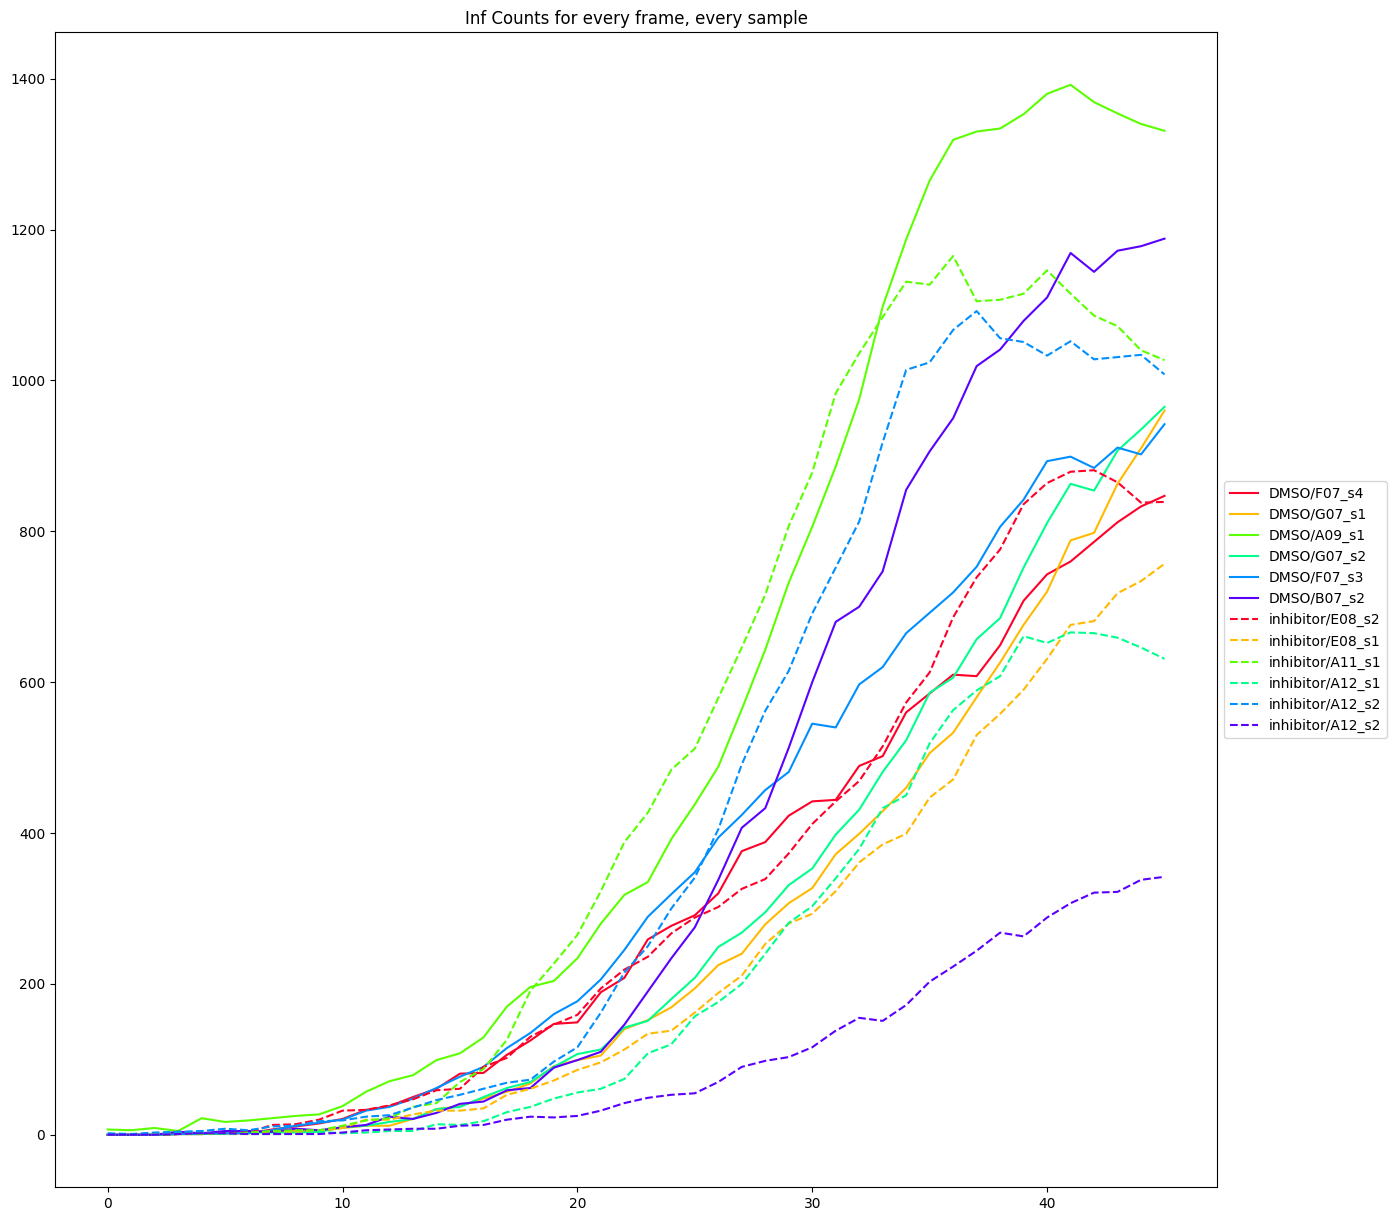

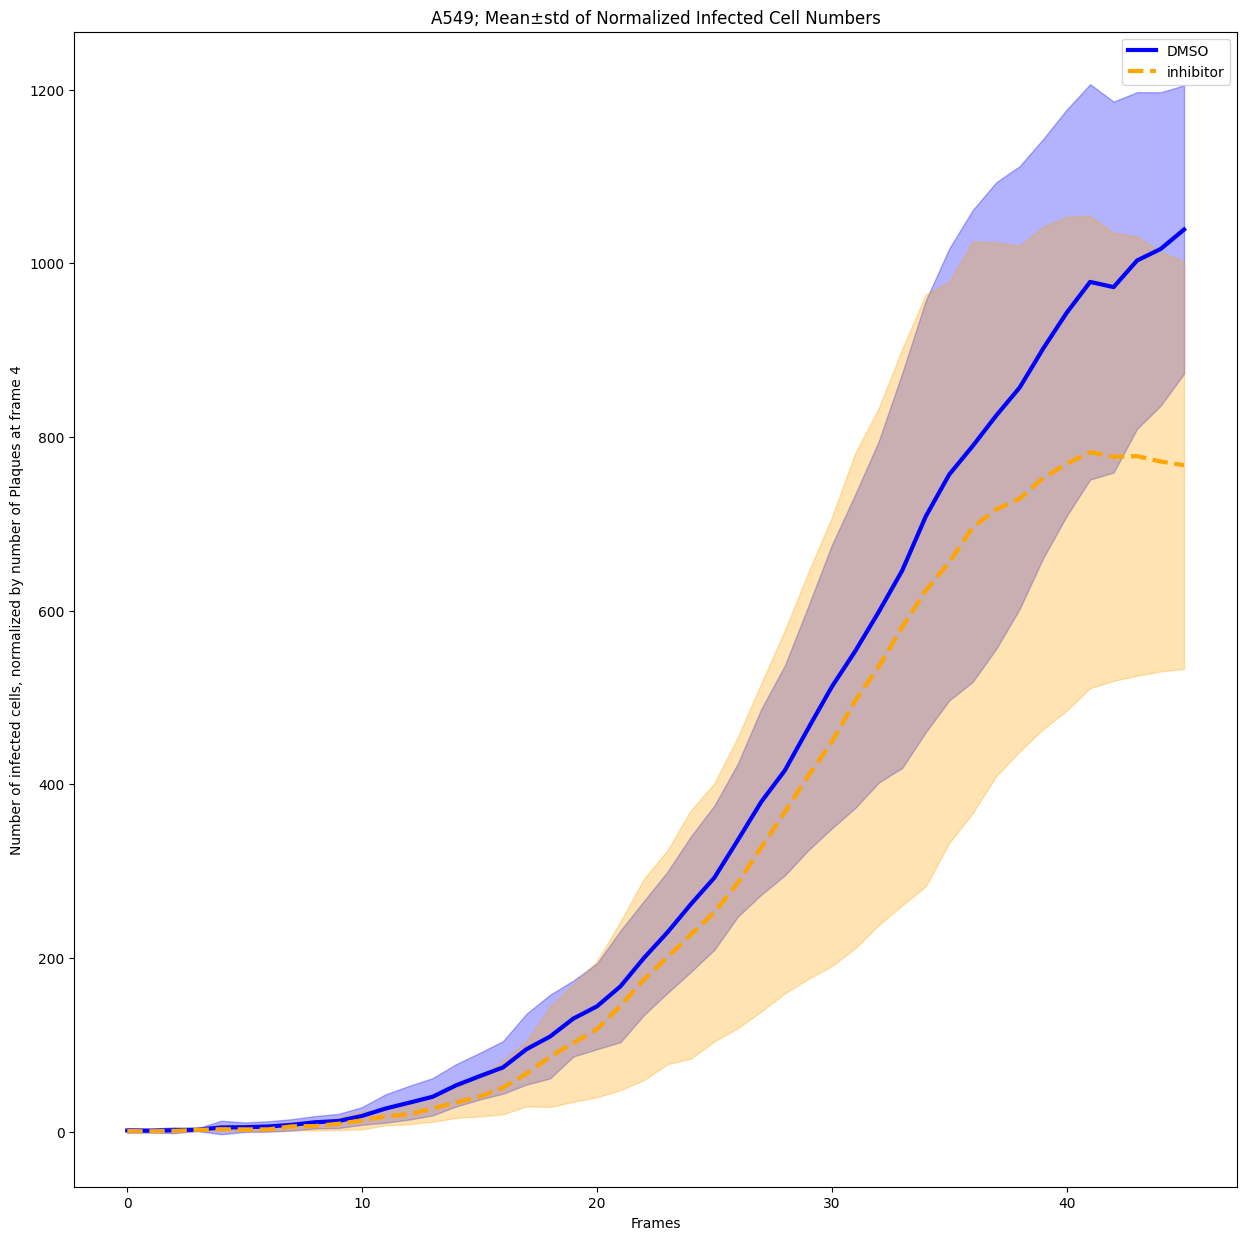

In [7]:
plot_group_statistics_all_together([dmso_csv_files, inhibitor_csv_files], DB_EPS, DB_MIN_SAMPLES, frame_to_normalize_by_plaques=FRAME, names=["DMSO", 'inhibitor'], title="A549; Mean±std of Normalized Infected Cell Numbers", savepath=SAVE_ROOT/f'A549-non-syncytia.pdf')

# T-test

In [17]:
# T test for last frame
import scipy.stats as stats

dmso_counts_last_frame = [frame_counts(csv_file, frames=45) for csv_file in dmso_csv_files]
inhibitor_counts_last_frame = [frame_counts(csv_file, frames=45) for csv_file in inhibitor_csv_files]
print('DMSO:')
print('\n'.join([f'{fn}: {count}' for fn, count in zip(dmso_csv_files, dmso_counts_last_frame)]))

print('Inhibitor:')
print('\n'.join([f'{fn}: {count}' for fn, count in zip(inhibitor_csv_files, inhibitor_counts_last_frame)]))

DMSO:
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/DMSO/F07_s4-all-spots.csv: [847]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/DMSO/G07_s1-all-spots.csv: [960]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/DMSO/A09_s1-all-spots.csv: [1331]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/DMSO/G07_s2-all-spots.csv: [965]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/DMSO/F07_s3-all-spots.csv: [942]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/DMSO/B07_s2-all-spots.csv: [1188]
Inhibitor:
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/inhibitor/E08_s2-all-spots.csv: [839]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/trackmate/non-syncytia/inhibitor/E08_s1-all-spots.csv: [757]
/Users/ashkanhzdr/workspace/ViralTally/dataset/Sars

In [18]:
stats.ttest_ind(dmso_counts_last_frame, inhibitor_counts_last_frame)

TtestResult(statistic=array([2.11247233]), pvalue=array([0.06078882]), df=array([10.]))

In [19]:
stats.ttest_ind(dmso_counts_last_frame, inhibitor_counts_last_frame, equal_var=False)

TtestResult(statistic=array([2.11247233]), pvalue=array([0.06379294]), df=array([9.00598263]))

# Corrected chi squared for small sample size
To compute a single p-value for comparing two curves, where each point has a
small sample size (t-student dist. instead of normal).
Null hypothesis: for each time-point (point on x-axis), points are samples from
the same parent distributions.

In [36]:
import numpy as np
from scipy import stats

frames = list(np.arange(0, 46))
dmso_counts = [frame_counts(csv_file, frames=frames) for csv_file in dmso_csv_files]
inhibitor_counts = [frame_counts(csv_file, frames=frames) for csv_file in inhibitor_csv_files]

dmso_stacked = np.vstack([dmso_counts]).T
inhibitor_stacked = np.vstack([inhibitor_counts]).T

dmso_mean = dmso_stacked.mean(axis=1)
inhibitor_mean = inhibitor_stacked.mean(axis=1)

N_dmso = dmso_stacked.shape[1]
N_inhibitor = inhibitor_stacked.shape[1]
N = min(dmso_stacked.shape[1], inhibitor_stacked.shape[1])

dmso_se = dmso_stacked.std(axis=1) / np.sqrt(N_dmso)
inhibitor_se = inhibitor_stacked.std(axis=1) / np.sqrt(N_inhibitor)

t_values = (dmso_mean - inhibitor_mean)/np.sqrt(dmso_se**2 + inhibitor_se**2)
doF = 2*N - 2

probs = 2 * (1 - stats.t.cdf(t_values, doF))

chi_squared = stats.chi2.isf(probs, 1)

p_value = 1 - stats.chi2.cdf(sum(chi_squared), len(chi_squared))
# p_value = 1 - stats.chi2.cdf(19.7798, 8)
print(p_value)

0.7182316337264535
